# Wildfire Forecasting: Quantile Regression on Fire Size

This notebook can be used for training a regression model for forecasting wildfire size in hectares. It is intended to be a step-by-step tutorial. We are using the 1 degree version of the [SeasFire Datacube](https://zenodo.org/record/7108392). You can also use the 0.25 degree version, but you might get out of memory errors. The datacube has to be downloaded first. It has many different variables that are all described on the zenodo page. For simplicity sake, we use only a subset. 

This tutorial is intended to be run on Google Colab with the data stored in Google Drive. You might need to adjust some paths etc. in order to run it locally.

🔥 
**Here you can define which variables from the datacube you want and which datacube you want, into how many quantiles you want to divide the fire sizes. You can also choose the target variable and if you want to train with unmasked or masked loss.**

In [1]:
NO_QUANTILES = 25
DEG_DATACUBE = 1
LOSS = "masked"
DELTA_TIME = 2
VARIABLES_SELECTED = ['rel_hum', 'ndvi', 'pop_dens_LOG',
                      'tp_LOG', 'sst', 'gwis_ba', 'lst_day']
TARGET = 'gwis_ba'
PATH_DATACUBE = "...."
# example 
# PATH_DATACUBE = str(Path.cwd().parent.parent / "data/raw/tiny_seasfire_europe_2019_2020_7vars.nc")

## Imports

In [2]:
%%capture
# 🔥 If working on colab

#  1. uncomment the following:

# ## 1a. install packages
# %pip install ipywidgets ipyleaflet ipympl -q
# %pip install captum zarr geopandas shapely -q
# %pip install rioxarray -q
# ## 1b. allow permission to connect to your google drive
# from google.colab import drive
# drive.mount('/content/drive')
# ## 1b. copy files 
# !git clone https://github.com/PiSchool/noa-xai-for-wildfire-forecasting.git
# %pip install ipywidgets ipyleaflet ipympl -q
# %pip install captum zarr geopandas shapely -q
# %pip install rioxarray -q
# import os
# os.chdir("/content/noa-xai-for-wildfire-forecasting")

In [3]:
%%capture 
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent.parent))
import os
import shutil
import gc
import geopandas as gpd
import xarray as xr
# import cv2
import json 
import time
import tqdm
import random
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tq
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm as ntqdm

from typing import List
import scipy
from scipy.stats import boxcox

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# import albumentations as albu

plt.style.use('bmh')

In [4]:
from utils.plots import visualize_batch_prediction
from utils.dataloader import create_datasets_model
from utils.general import seed_everything
from utils.model import UNet

In [5]:
train_on_gpu = torch.cuda.is_available()
print(f"GPU available? {train_on_gpu}")
SEED = 172
MODEL_NO = 0 # in K-fold
N_FOLDS = 10 # in K-fold
seed_everything(SEED)

GPU available? False


## Load data set

First, we need to load the dataset and perform some calculations for normalising the data. We also calculate the quantiles here.

🔥 **You might need to adjust some paths to reflect your file structure here!**

In [6]:
%%capture
# if DEG_DATACUBE == 1:
#   ds = xr.open_zarr('/content/drive/MyDrive/seasfire_1deg.zarr') #edit to your path
# else:
#   ds = xr.open_zarr('/content/drive/MyDrive/seasfire.zarr').     #edit to your path


if PATH_DATACUBE.endswith(".zarr"):
  ds = xr.open_zarr(PATH_DATACUBE)
else:
  ds = xr.open_dataset(PATH_DATACUBE)


mask = xr.where(ds.lsm>=0.9,1,0).astype(bool)

# put the log for population_density and total_precipitation (there are too many 0 entries)
ds = ds.assign(pop_dens_LOG = lambda x: np.log(1+x['pop_dens']))
ds = ds.assign(tp_LOG = lambda x: np.log(1+x['tp']))
# ds = ds.assign(fcci_ba = lambda x: np.log(x['gwis_ba']))

The data used has very different distributions (e.g. temperatures are given in Kelvin, but the Normalized Difference Vegetation Index is only defined in the range (-1, 1). In order to make it easier for the model to learn, we normalise all data to have a mean of 0, and a standard deviation of 1. The normalisation itself is done in the dataloader, but we calculate the means and standard deviations here.

🔥 **You might need to adjust some paths to reflect your file structure here!**

In [7]:
# CSV file path
file_mean_std = Path().cwd().parent.parent / f'table_mean_std_{DEG_DATACUBE}deg_{"_".join(VARIABLES_SELECTED)}.csv' 

if not Path(file_mean_std).exists():
  ### SAVE IN A TABLE GLOBAL MEAN AND STD for EACH VARIABLE
  vmean = ds.mean()[VARIABLES_SELECTED].load().to_pandas()
  vmean.name = 'mean'
  vstd  = ds.std() [VARIABLES_SELECTED].load().to_pandas()
  vstd.name  = 'std'
  table_mean_std = pd.concat([vmean, vstd], axis=1)
  table_mean_std.to_csv(file_mean_std)
else:
  table_mean_std = pd.read_csv(file_mean_std, index_col = 0, header = 0)

table_mean_std

,mean,std
rel_hum,63.034214,20.648024
ndvi,0.360180,0.262146
pop_dens_LOG,2.672613,1.799556
tp_LOG,1.842019,1.380430
sst,288.914398,7.228608
gwis_ba,5.138694,111.361160
lst_day,293.536987,17.397209


The raw values of the burned area in hectares have a quite large range from `0` to almost `1,000,000` hecatares in a `1 degree x 1 degree` pixel. We calculate the quantiles of fire sizes excluding 0 values and NaNs in the sea surface (otherwise, the data is too skewed).

🔥 **You might need to adjust some paths to reflect your file structure here!**
🔥

In [8]:
# CSV file path
file_fire_quantiles = Path().cwd().parent.parent / f'fire_quantiles_{DEG_DATACUBE}deg_{NO_QUANTILES}.csv'

quantiles = np.linspace(0, 1, num=NO_QUANTILES)
if not Path(file_fire_quantiles).exists():
  gwis_array = np.asarray(ds.gwis_ba)
  quantiles_gwis = np.nanquantile(gwis_array[gwis_array>0.0], quantiles)
  fcci_array = np.asarray(ds.fcci_ba)
  quantiles_fcci = np.nanquantile(fcci_array[fcci_array>0.0], quantiles)

  fire_quantiles = pd.DataFrame([list(quantiles_fcci), list(quantiles_gwis)], ["fcci_ba", "gwis_ba"], quantiles)
  fire_quantiles.to_csv(file_fire_quantiles)

else:
  fire_quantiles = pd.read_csv(file_fire_quantiles, index_col = 0, header = 0)

fire_quantiles

,0.0,0.041666666666666664,0.08333333333333333,0.125,0.16666666666666666,0.20833333333333331,0.25,0.29166666666666663,0.3333333333333333,0.375,...,0.625,0.6666666666666666,0.7083333333333333,0.75,0.7916666666666666,0.8333333333333333,0.875,0.9166666666666666,0.9583333333333333,1.0
fcci_ba,1.177362e+00,2.649139,2.749341,3.112582,3.324069,3.391642,3.559104,3.763944,3.944229,4.092108,...,5.154079,5.334942,5.519409,5.725992,5.944766,6.188766,6.466798,6.832968,7.371591,10.233323
gwis_ba,1.876346e-08,13.521146,14.867499,17.518870,26.476734,28.936707,34.243690,42.134727,49.815929,57.380800,...,169.768005,202.360107,243.459555,299.871811,374.758896,479.136978,634.603340,915.795217,1569.814143,27814.777344


Build a custom Dataset Class (following [PyTorch advices](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files))

🔥 **Here the quantiles are assigned to the target in __getitem__() (if self.fire_quantiles is not None)**

What I am trying to do is this, imagine if these are the burned area values that we have in the whole dataset:

1.   I start from the raw burned area values (without NaNs and 0s), e.g. **[1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 5, 6, 7, 8, 8, 9, 10]**
2.   I want e.g. 5 quantiles  so the **0, 0.25, 0.5, 0.75 and 1** quantiles!
3. I calculate the values for the quantiles: **1, 1.75, 3, 6.25, 10**

In the **itemgetter** function I then change the burned areas to the enumerated quantile they are in (NaNs are turned into -1 and 0 stay 0) So e.g.:

`[[0, 0, NaN], [1, 1, 2], [5, 6, 8]]` would be turned into:
`[[0, 0, -1], [0.25, 0.25, 0.5], [0.75, 1, 1]]`


In [9]:
ds = ds.chunk(dict(time = len(ds.time),
                   latitude = 90, 
                   longitude = 90))

train_dataset, valid_dataset, test_dataset = create_datasets_model(ds[VARIABLES_SELECTED], 
                                                                   slice_train = slice('20190101', '20211231'), #slice('20030101', '20161231'),
                                                                   slice_valid = slice('20190101', '20211231'), #slice('20170101', '20181231'), 
                                                                   slice_test  = None,#slice('20190101', '20211231'), #None,
                                                                   table_mean_std = table_mean_std,
                                                                   fire_quantiles = fire_quantiles,
                                                                   target='gwis_ba', delta_time = DELTA_TIME, inland_map = mask)

check on chuncks with fire:   0%|          | 0/2 [00:00<?, ?it/s]

out of 368 chuncks, 321 have at least 1 fire pixel (87.23%)


loading in memory:   0%|          | 0/4 [00:00<?, ?it/s]

check on chuncks with fire:   0%|          | 0/2 [00:00<?, ?it/s]

out of 368 chuncks, 321 have at least 1 fire pixel (87.23%)


loading in memory:   0%|          | 0/4 [00:00<?, ?it/s]

## Model Definition

U-Net was originally invented and first used for biomedical image segmentation (here the [original paper](https://arxiv.org/pdf/1505.04597.pdf)). Its architecture can be broadly thought of as an encoder network (contraction block), a bottleneck, followed by a decoder network (expansion section).

I you wish to deep dive into U-Net and Image Segmentation, here a [detailed blog post](https://www.jeremyjordan.me/semantic-segmentation/).

In [10]:
model = UNet(n_channels=len(train_dataset.features), 
             n_classes=1,
             regression=True).float()
             
if train_on_gpu:
    model.cuda()

## Training Loop

In [11]:
num_workers = 0
bs = 4

# DataLoader to batch the images
train_loader = DataLoader(
    train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)

valid_loader = DataLoader(
    valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

In [12]:
# from torchsummary import summary
from torch.nn import MSELoss
import warnings

#ignore some deprecation warnings
warnings.filterwarnings("ignore", category=UserWarning) 

model = UNet(n_channels=len(train_dataset.features), n_classes=1, regression=True).float()
if train_on_gpu:
    model.cuda()

In [13]:
optimizer = optim.Adam(model.parameters(), lr = 0.005)
train_loss_list, valid_loss_list, dice_score_list, lr_rate_list, valid_loss_min = model.train_model(
                                                                                          train_loader = train_loader,
                                                                                          valid_loader = valid_loader,
                                                                                          n_epochs = 1,
                                                                                          t_mask = None,
                                                                                          criterion = MSELoss(), #Dice is used for segmentation
                                                                                          optimizer = optimizer,
                                                                                          scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)
                                                                                      )

epoch: 1


  0%|          | 0/81 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/81 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 1  Training Loss: 0.503554  Validation Loss: 0.303303 Dice Score: -1.468329
Validation loss decreased (inf --> 0.303303).  Saving model ...


### VIsualization of the model losses

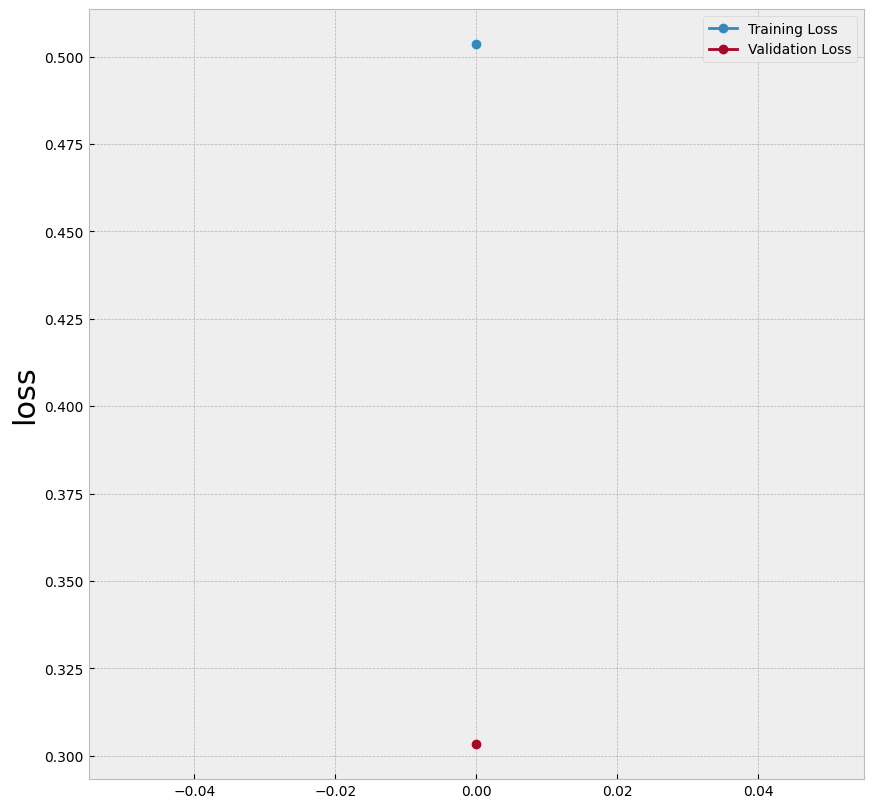

In [14]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('loss', fontsize=22)
plt.legend()
plt.show()

### Visual comparison of the prediction on the test dataset

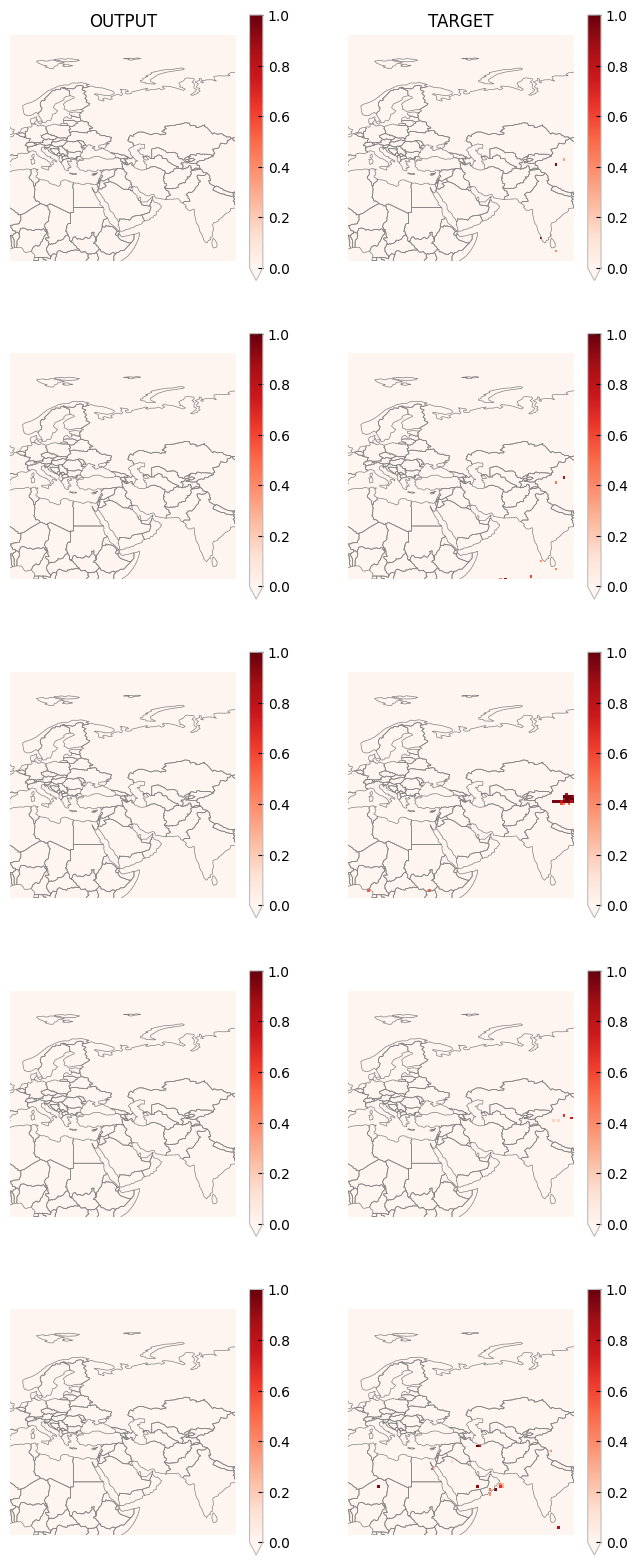

In [15]:
model.eval()
visualize_batch_prediction(model, valid_loader, n_images = 5,
                           predict_on_gpu=train_on_gpu, 
                            x_coords=valid_dataset.ds.longitude.isel(longitude = valid_dataset.accepted_slices.longitude[0]),
                            y_coords=valid_dataset.ds.latitude.isel(latitude = valid_dataset.accepted_slices.latitude[0]),
                           cmap = 'Reds', vmin = 0, vmax = 1)